# BERT

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch     
import pandas as pd
import evaluate
metric = evaluate.load("accuracy")

In [5]:
model_name = "C:/Users/imruh/Documents/Uni/Master thesis/classifiers/models/bert_finetuned_reverse_test"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

OSError: Incorrect path_or_model_id: 'C:/Users/imruh/Documents/Uni/Master thesis/classifiers/models/bert_finetuned_reverse_test'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [2]:
df = pd.read_csv("../preprocessing/data/processed_merge.csv", encoding='utf8', index_col=False).drop(['Unnamed: 0'], axis=1).dropna()

In [3]:
df = pd.concat([df[df["label"]==1].sample(n=1000),df[df["label"]==0].sample(n=1000)]).sample(frac=1)

In [27]:
df

,Unnamed: 0.1,scenario,source_file,original_text,preprocessed_text,label
20263,20263,Umbrella,kurland24b.cha,"and she's like +""/. 329984_330474",and she is like.,1
38831,38831,Cinderella,1008-LARC.cha,&-um &-um but [//] and see and you look like &...,but and see and you look like say.,1
30867,30867,Cinderella,6-1.cha,"+"" xxx who the heck is this ? 1378918_1380568",who the heck is this?,0
42797,42797,Cat,UNH17a.cha,&=coughs &-um <the [/] &+do the girl> [//] the...,the the girl the the dog is barking with the w...,1
13095,13095,Stroke,UNH17a.cha,<and then> [/] and then awake . [+ gram] 1638...,and then and then awake.,1
...,...,...,...,...,...,...
33989,33989,Important_Event,capilouto65a.cha,expandin(g) . 749628_750178,expanding.,0
10299,10299,Window,wright207a.cha,okay . [+ exc] 415071_415421,okay.,1
2477,2477,Cinderella,20-1.cha,and they stuck out their feet . 2238030_2239200,and they stuck out their feet.,0
34179,34179,Cinderella,elman11a.cha,thank_you . [+ exc] 995325_995765,thank you.,1


In [46]:
sentences = df["preprocessed_text"]
labels = df["label"]

In [47]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [48]:
pd.Series(labels).value_counts()

0    27085
1     3574
Name: count, dtype: int64

In [49]:
pred_labels_bert = []
true_labels = []

for sentence, label in zip(sentences, labels):
    if sentence is not None and isinstance(sentence, str):
        
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True).input_ids.to(device) 
        true_labels.append(label)
        with torch.no_grad():
            logits = model(inputs).logits
        predicted_class_id = logits.argmax().item()
        pred_labels_bert.append(predicted_class_id)

In [33]:
df["predicted"] = pred_labels_bert

In [13]:
df.to_csv("../linguistic_model/data/answers.csv")

In [50]:
print(f"BERT Accuracy: {metric.compute(predictions=pred_labels_bert, references=true_labels)}")

BERT Accuracy: {'accuracy': 0.8876675690661796}


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (30661).

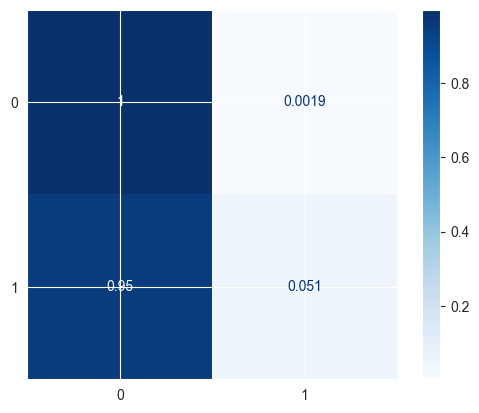

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels_bert, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels_bert, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

# Visualize attention

In [17]:
# from bertviz import model_view, head_view
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
# import torch
# 
# tokenizer = AutoTokenizer.from_pretrained("models/bert_finetuned_reverse", return_tensor="pt")
# model = AutoModel.from_pretrained("models/bert_finetuned_reverse")
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [18]:
# print(sentences[10], labels[10])

In [19]:
# sentence = '"those are that an slashes is watching, right?"'
# label = "1"
# input = tokenizer.encode(sentence, return_tensors="pt")
# output = model(input, output_attentions=True)
# 
# attention = output[-1]
# tokens = tokenizer.convert_ids_to_tokens(input[0]) 
# model_view(attention, tokens)
# print(sentence, label)

# KNN 

In [20]:
# from gensim.models import Word2Vec
# import numpy as np
# import pickle

In [21]:
w2v_model = Word2Vec.load("models/word2vec_knn_reverse.model")
vocab=list(w2v_model.wv.key_to_index.keys())
loaded_model = pickle.load(open('models/knn_reverse_pickle', 'rb'))

NameError: name 'Word2Vec' is not defined

In [ ]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [ ]:
transformed_text, labels1= avg_w2vec(sentences, labels)

In [ ]:
pred_labels_knn = loaded_model.predict(transformed_text)

In [ ]:
print(len(pred_labels_knn))
print(len(transformed_text))

In [ ]:
print(f"KNN Accuracy: {metric.compute(predictions=pred_labels_knn, references=labels1)}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels1, pred_labels_knn, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(labels1, pred_labels_knn, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

# Random forest

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
w2v_model = Word2Vec.load("models/word2vec_rf_reverse.model")
vocab=list(w2v_model.wv.key_to_index.keys())

In [ ]:
loaded_model = pickle.load(open('models/rf_reverse_pickle', 'rb'))

In [ ]:
pred_labels_rf = loaded_model.predict(transformed_text)

In [ ]:
print(f"RF Accuracy: {metric.compute(predictions=pred_labels_rf, references=labels1)}")

In [ ]:
cm = confusion_matrix(labels1, pred_labels_rf, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(labels1, pred_labels_rf, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)